In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [2]:
#Load your dataset
df = pd.read_csv("transformed_data.csv")

#Ensure the 'Datum' column is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

#Define time ranges
train_start = '2013-07-01'
train_end = '2017-07-31'
val_start = '2017-08-01'
val_end = '2018-07-31'
test_start = '2018-08-01'
test_end = '2019-07-30'

#Split data
train_data = df[(df['Datum'] >= train_start) & (df['Datum'] <= train_end)]
validation_data = df[(df['Datum'] >= val_start) & (df['Datum'] <= val_end)]
test_data = df[(df['Datum'] >= test_start) & (df['Datum'] <= test_end)]

#Optional: print shapes
print("Train shape:", train_data.shape)
print("Validation shape:", validation_data.shape)
print("Test shape:", test_data.shape)

Train shape: (7517, 13)
Validation shape: (1839, 13)
Test shape: (351, 13)


In [8]:
train_data.head()

Datum Weekday  Bewoelkung  Temperatur  Windgeschwindigkeit  \
394 2013-07-01  Monday         6.0       17.84                   15   
395 2013-07-01  Monday         6.0       17.84                   15   
396 2013-07-01  Monday         6.0       17.84                   15   
397 2013-07-01  Monday         6.0       17.84                   15   
398 2013-07-01  Monday         6.0       17.84                   15   

     Wettercode         id Warengruppe  Umsatz  KielerWoche Weather_Category  \
394        20.0  1307011.0        Brot  148.83          NaN         Moderate   
395        20.0  1307012.0    Brötchen  535.86          NaN         Moderate   
396        20.0  1307013.0   Croissant  201.20          NaN         Moderate   
397        20.0  1307014.0  Konditorei   65.89          NaN         Moderate   
398        20.0  1307015.0      Kuchen  317.48          NaN         Moderate   

    Weather_Category_Wind_Adjusted  Wind_Downgrade_Count  
394                       Moderate                     0  
395                       Moderate                     0  
396                       Moderate                     0  
397                       Moderate                     0  
398                       Moderate                     0

Model with Warengruppe, Weekday and temperture

In [9]:
Y = train_data['Umsatz']
X = sm.add_constant(
	pd.get_dummies(train_data['Warengruppe'], drop_first=True, dtype=int)
	.join(pd.get_dummies(train_data['Weekday'], drop_first=True, dtype=int))
    .join(train_data['Temperatur'])
)

# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_test = Y[valid_idx]
X_test = X[valid_idx]

# change indices so that they start from 0
Y_test.index = range(len(Y_test))
X_test.index = range(len(X_test))

# Fit the model
model = sm.OLS(Y_test, X_test)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     1554.
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        16:06:24   Log-Likelihood:                -43342.
No. Observations:                7487   AIC:                         8.671e+04
Df Residuals:                    7474   BIC:                         8.680e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.2375      3.481     17.305      0.0

In [ ]:
prod1 = X_test.loc[0]
print(prod1)
print("Predicted value: ", results.predict(prod1).values) #predicted value for the first index
print("Actual value:", Y_test.loc[0])  # actual value for the first index

const          1.00
Brötchen       0.00
Croissant      0.00
Konditorei     0.00
Kuchen         0.00
Saisonbrot     0.00
Monday         1.00
Saturday       0.00
Sunday         0.00
Thursday       0.00
Tuesday        0.00
Wednesday      0.00
Temperatur    17.84
Name: 0, dtype: float64
Predicted value:  [131.32604458]
Actual value 148.83


In [12]:
predicted = results.predict(X_test)
predicted.describe()

count    7487.000000
mean      209.347524
std       124.851127
min        -0.860627
25%       108.384970
50%       171.926107
75%       300.901836
max       509.628578
dtype: float64

In [22]:
print("Predicted head:\n", predicted.head())
actual = Y_test
print("Actual head:\n", actual.head())

Predicted head:
 0    131.326045
1    420.490056
2    174.082355
3     98.234328
4    290.849467
dtype: float64
Actual head:
 0    148.83
1    535.86
2    201.20
3     65.89
4    317.48
Name: Umsatz, dtype: float64


Plot

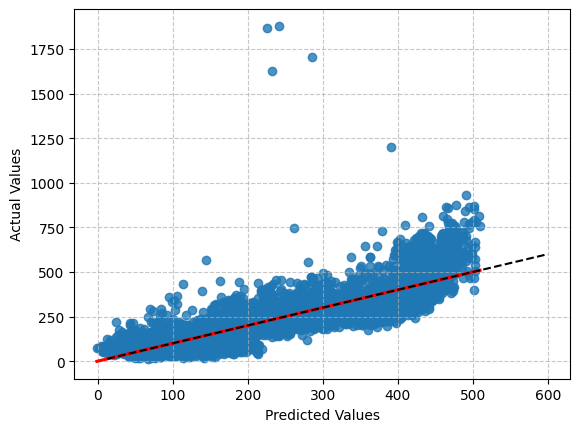

In [24]:
# Plotting the predicted vs actual values
sns.regplot(x=predicted, y=actual, line_kws={"color": "red"})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(alpha=0.7, linestyle='--')
# adding the perfect y=x line
min = actual.min()
max = 600
plt.plot([min, max], [min, max], color='black', linestyle='--')

Log transformation

In [27]:
# Log transformation of the dependent variable
# This is useful for stabilizing variance and making the data more normally distributed
Y = np.log(train_data['Umsatz'] + 1)
X = sm.add_constant(
	pd.get_dummies(train_data['Warengruppe'], drop_first=True, dtype=int)
	.join(pd.get_dummies(train_data['Weekday'], drop_first=True, dtype=int))
    .join(train_data['Temperatur'])
)

# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_test = Y[valid_idx]
X_test = X[valid_idx]

# change indices so that they start from 0
Y_test.index = range(len(Y_test))
X_test.index = range(len(X_test))

# Fit the model
model = sm.OLS(Y_test, X_test)
results = model.fit()

print(results.summary())

# To make predictions in original scale, use:
# predictions_original_scale = np.exp(results.predict(X_test)) - 1

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     2158.
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        16:25:57   Log-Likelihood:                -2120.6
No. Observations:                7487   AIC:                             4267.
Df Residuals:                    7474   BIC:                             4357.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5181      0.014    319.411      0.0

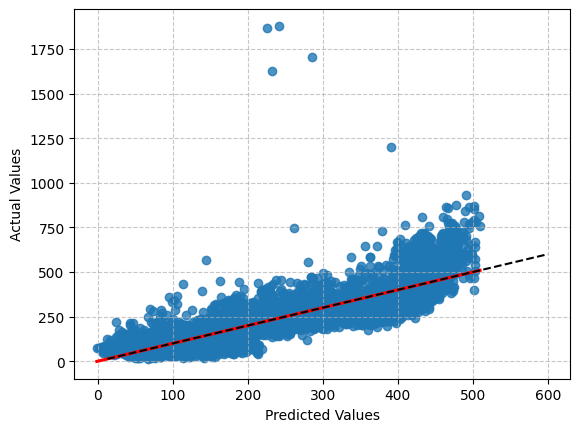

In [28]:
# Plotting the predicted vs actual values
sns.regplot(x=predicted, y=actual, line_kws={"color": "red"})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(alpha=0.7, linestyle='--')
# adding the perfect y=x line
min = actual.min()
max = 600
plt.plot([min, max], [min, max], color='black', linestyle='--')